In [22]:
import json
from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    ChatMessage,
    FunctionMessage,
    HumanMessage,
)
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation
from langchain_core.tools import tool
from langchain.tools import Tool,DuckDuckGoSearchRun
tavily_tool = DuckDuckGoSearchRun()

In [23]:
from langchain_experimental.utilities import PythonREPL
from typing import Annotated

In [24]:
repl = PythonREPL()
@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

<>:12: SyntaxWarning: invalid escape sequence '\`'
<>:12: SyntaxWarning: invalid escape sequence '\`'
<>:12: SyntaxWarning: invalid escape sequence '\`'
<>:12: SyntaxWarning: invalid escape sequence '\`'
/tmp/ipykernel_321107/4169225838.py:12: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
/tmp/ipykernel_321107/4169225838.py:12: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [25]:
tools = [tavily_tool, python_repl]


In [26]:
import operator
from typing import Annotated, List, Sequence, Tuple, TypedDict, Union

In [27]:
from langchain.agents import create_openai_functions_agent
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [28]:
tool_executor = ToolExecutor(tools)


/tmp/ipykernel_321107/3965633045.py:1: LangGraphDeprecationWarning: ToolExecutor is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  tool_executor = ToolExecutor(tools)


In [29]:
def tool_node(state):
    """This runs tools in the graph
    It takes in an agent action and calls that tool and returns the result."""
    messages = state["messages"]
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    tool_input = json.loads(
        last_message.additional_kwargs["function_call"]["arguments"]
    )
    # We can pass single-arg inputs by value
    if len(tool_input) == 1 and "__arg1" in tool_input:
        tool_input = next(iter(tool_input.values()))
    tool_name = last_message.additional_kwargs["function_call"]["name"]
    action = ToolInvocation(
        tool=tool_name,
        tool_input=tool_input,
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    # We use the response to create a FunctionMessage
    function_message = FunctionMessage(
        content=f"{tool_name} response: {str(response)}", name=action.tool
    )
    # We return a list, because this will get added to the existing list
    return {"messages": [function_message]}

In [30]:
# Either agent can decide to end
def router(state):
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "function_call" in last_message.additional_kwargs:
        # The previus agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "end"
    return "continue"

In [31]:
from langchain_groq import ChatGroq
# Initialize the Groq LLM
llm = ChatGroq(
        model_name="llama-3.1-70b-versatile",
        temperature=0.1,
        model_kwargs={"top_p": 0.5, "seed": 1337}
    )

In [32]:
import json
from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    ChatMessage,
    FunctionMessage,
    HumanMessage,
)
from langchain_core.utils.function_calling import convert_to_openai_function
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation
def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    functions = [convert_to_openai_function(t) for t in tools]
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\\\\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_functions(functions)

In [33]:
# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, FunctionMessage):
        pass
    else:
        result = HumanMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }

In [34]:
research_agent= create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart generator to use.",
)

In [35]:
chart_agent= create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)

In [36]:
import functools
research_node= functools.partial(agent_node, agent=research_agent, name="Researcher")

chart_node= functools.partial(agent_node, agent=chart_agent, name="Chart Generator")


In [37]:
workflow= StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("Chart Generator", chart_node)
workflow.add_node("call_tool", tool_node)
workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "Chart Generator", "call_tool": "call_tool", "end": END},
)
workflow.add_conditional_edges(
    "Chart Generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "end": END},
)
workflow.add_conditional_edges(
    "call_tool",
# Each agent node updates the 'sender' field# the tool calling node does not, meaning
# this edge will route back to the original agent# who invoked the tool
		lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "Chart Generator": "Chart Generator",
    },
)
workflow.set_entry_point("Researcher")
graph= workflow.compile()

In [38]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the Malaysia's GDP over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
):
    print(s)
    print("----")

{'Researcher': {'messages': [HumanMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bc6f', 'function': {'arguments': '{"query": "Malaysia GDP past 5 years"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 407, 'total_tokens': 430, 'completion_time': 0.092, 'prompt_time': 0.121696114, 'queue_time': 0.005178352999999997, 'total_time': 0.213696114}, 'model_name': 'llama-3.1-70b-versatile', 'system_fingerprint': 'fp_b3ae7e594e', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-61ff1bed-15c9-4bf3-a639-4dd976639132-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'Malaysia GDP past 5 years'}, 'id': 'call_bc6f', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata=None)], 'sender': 'Researcher'}}
----
{'Chart Generator': {'messages': [HumanMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_r2pg', 'function': {'arguments': '{"co

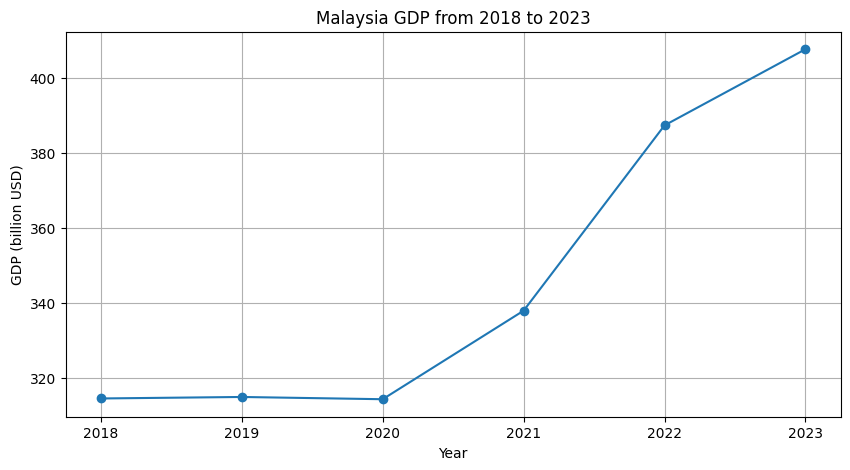

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

data = { "year": [2018, 2019, 2020, 2021, 2022, 2023],
        "gdp": [314.5, 314.9, 314.3, 337.9, 387.3, 407.6]}
df = pd.DataFrame(data)
plt.figure(figsize=(10,5))
plt.plot(df["year"], df["gdp"], marker="o")
plt.title("Malaysia GDP from 2018 to 2023")
plt.xlabel("Year")
plt.ylabel("GDP (billion USD)")
plt.grid(True)
plt.show()